<a href="https://colab.research.google.com/github/AbeRodz/computer-vision-II/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

In [10]:
!nvidia-smi

Sun Jul 30 19:34:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |    103MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import cv2 as cv
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [ ]:
torch.cuda.get_device_capability()

In [ ]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

La siguiente linea es un optimizador de cudnn

In [ ]:
torch.backends.cudnn.benchmark = True

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
cd /content/drive/MyDrive/dataset/vision/kitti

/content/drive/MyDrive/dataset/vision/kitti


In [13]:
# Load directories
train_data_dir = "./training/image_2/"
train_gt_dir = "./training/gt_image_2/"

test_data_dir = "./testing/"

In [14]:
train_data_dir

'./training/image_2/'

In [15]:
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [16]:
def open_images(path, masked = False):
  temp = []
  def read_image(image):

    return Image.open(os.path.join(path,image)).resize((128, 128))

  images = os.listdir(path)
  images=sorted(images)
  if masked==True:
    images = [entry for entry in images if "road" in entry]

  with ThreadPoolExecutor() as executor:
    files = executor.map(read_image,images)
    for f in files:
      temp.append(np.asarray(f))
  return np.array(temp)

In [17]:
data=open_images(train_data_dir,masked=False)

In [18]:
data.shape

(289, 128, 128, 3)

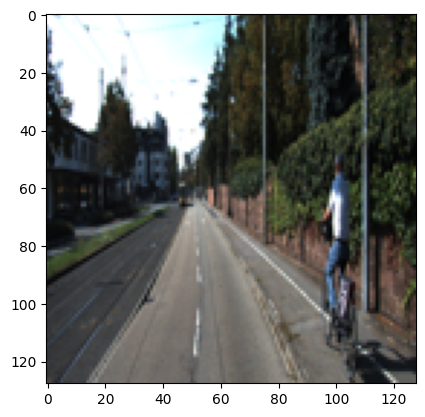

In [19]:
plt.imshow(data[0])

In [20]:
true_mask=open_images(train_gt_dir,masked=True)

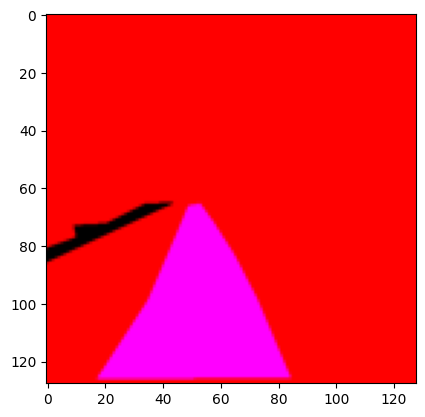

In [21]:
plt.imshow(true_mask[0])

In [22]:
def convert_to_binary_mask(true_mask):
    noMasks=len(true_mask)
    for i in range(noMasks):
        #convert all masks to just binary masks (road and no road)
        road_label =np.array([255, 0, 255])
        cond=np.all(true_mask[i] == road_label, axis = 2)
        true_mask[i]=true_mask[i] * cond[..., np.newaxis]

In [23]:
convert_to_binary_mask(true_mask)

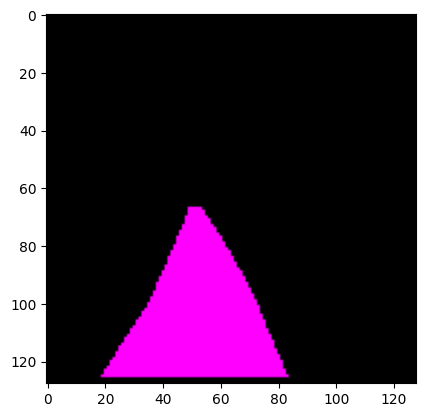

In [24]:
plt.imshow(true_mask[0])

In [25]:
true_mask=np.dot(true_mask[..., :3], [0.2989, 0.5870, 0.1140])
true_mask=np.expand_dims(true_mask, axis=-1)

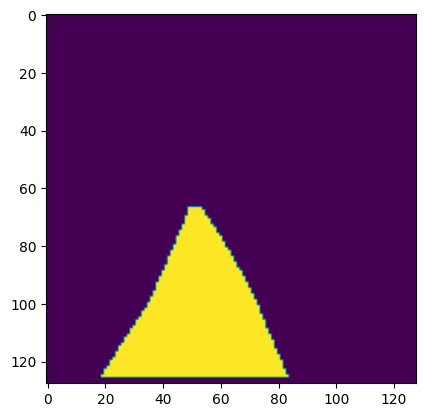

In [26]:
plt.imshow(true_mask[0])

In [27]:
true_mask[true_mask != 0.0]=1.0

In [28]:
data  = data / 255.0

## Data Augmentation

In [29]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5,border_mode=cv.BORDER_CONSTANT),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])

In [30]:
data=data.astype(np.float32)
true_mask=true_mask.astype(np.float32)

In [31]:
test_aug=augmentation_pipeline(image=data[5], mask=true_mask[5])
test_example=test_aug["image"]
test_mask=test_aug["mask"]

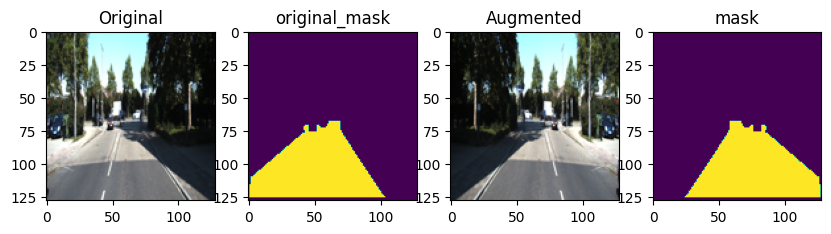

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[5])
ax[0].set_title("Original")

ax[1].imshow(true_mask[5])
ax[1].set_title("original_mask")


ax[2].imshow(test_example)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()

In [33]:
num_augmented=3
for i in range(len(data)):
    for j in range(num_augmented):
      image = data[i]
      mask = true_mask[i]

      augmented = augmentation_pipeline(image=image, mask=mask)

      image_augmented = augmented["image"]
      mask_augmented = augmented["mask"]
      data = np.vstack((data, image_augmented[np.newaxis,...]))
      true_mask = np.vstack((true_mask, mask_augmented[np.newaxis,...]))

In [34]:
data.shape

(1156, 128, 128, 3)

In [35]:
true_mask.shape

(1156, 128, 128, 1)

In [36]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, true_mask,test_size = 0.1, random_state =42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size = 0.1, random_state =42, shuffle = True)

In [ ]:
X_train= X_train.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))
y_train = y_train.transpose((0, 3, 1, 2))
y_test=y_test.transpose((0, 3, 1, 2))
X_val=X_val.transpose((0, 3, 1, 2))
y_val=y_val.transpose((0, 3, 1, 2))

In [ ]:
X_train.shape

In [37]:
train_set_size = int(len(data) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(data) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = len(data) - train_set_size - validation_set_size
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 924
Number of Validation Examples: 115
Number of Testing Examples: 117


In [38]:
X_test=data[:test_set_size].transpose((0, 3, 1, 2))
y_test=true_mask[:test_set_size].transpose((0, 3, 1, 2))
print(f'test set size {X_test.shape}')


#rest of the data will be agumented and shuffled for training
data=data[test_set_size:]
true_mask=true_mask[test_set_size:]

# Shuffle the indices
shuffled_indices = np.random.permutation(len(data))

# Use the shuffled indices to shuffle both arrays
shuffled_data = data[shuffled_indices]
shuffled_masks = true_mask[shuffled_indices]

test set size (117, 3, 128, 128)


In [39]:
#train_test_validation split
X_train=shuffled_data[:train_set_size].transpose((0, 3, 1, 2))
y_train=shuffled_masks[:train_set_size].transpose((0, 3, 1, 2))
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
y_val=shuffled_masks[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
print(f'val set size {X_val.shape}')

training set size (924, 3, 128, 128)
val set size (115, 3, 128, 128)


In [40]:
#create dataset class
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, imgs,mask):
        self.imgs=imgs
        self.mask=mask

    def __len__(self):
        return len(self.imgs)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.imgs[idx]

    def get_batch_masks(self, idx):
    # Fetch a batch of inputs
        return self.mask[idx]


    def __getitem__(self, index):
        imgs=self.get_batch_imgs(index)
        masks=self.get_batch_masks(index)
        return imgs,masks

Dataloaders Asincronos

In [41]:
train_dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

# Create a DataLoader from the dataset
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader=DataLoader(val_dataset, batch_size=32, shuffle=True)
# test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
val_dataloader=DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=2,pin_memory=True)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=2,pin_memory=True)

print(f"Train dataloader length: {len(train_dataloader)} batches of size {64}")
print(f"Validation dataloader length: {len(val_dataloader)} batches of size {64}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {64}")

Train dataloader length: 29 batches of size 64
Validation dataloader length: 4 batches of size 64
Test dataloader length: 4 batches of size 64


# Creando U-NET

### Loss function

In [42]:
class IoULoss(torch.nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.eps = 1e-6

    def forward(self, y_pred : torch.Tensor, y_true: torch.Tensor):
        # Flatten tensors
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        intersection = (y_pred * y_true).sum()
        total = y_pred.sum() + y_true.sum()
        union = total - intersection

        # Calculate the IoU  loss
        iou = intersection / (union + self.eps)
        return 1 - iou

## U-Net

In [43]:
import torchvision.transforms.functional as TF

In [44]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__() # essentail to use torch.nn.Module
        #ex : for the first layer
        #in_channels would be 3 for RGB image
        #out_channels would be 64
        #bias is set to false because we apply batch norm later so it's unnecassary
        self.dconv=torch.nn.Sequential(torch.nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
                                 torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.dconv(x)



class UNET(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()

        self.ups = torch.nn.ModuleList()
        self.downs = torch.nn.ModuleList()

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(torch.nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #this is not deconv this just upsampling
            self.ups.append(DoubleConv(feature*2, feature))



        self.left_over = DoubleConv(features[-1], features[-1]*2) #this represents the last part which starts the UP phase

        self.final_conv = torch.nn.Conv2d(features[0], out_channels, kernel_size=1) #output segmentation  map

    def forward(self,x):
        skip_connections = []

        #starting the down phase will iterate through the downs module
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x)#save this to feed it later
            x=self.pool(x)

        #to move from left to right we pass through the "left_over"

        x=self.left_over(x)
        skip_connections=skip_connections[::-1]
        for idx in range(0,len(self.ups), 2): #our goal it so feed to transposed conv and add skipped connection ups has 2 steps in each so we will make it a step of 2

            sc=skip_connections[idx//2]
            x=self.ups[idx](x) #step 1

            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1) #concatination step
            x = self.ups[idx+1](concat_skip) #step 2


        return torch.sigmoid(self.final_conv(x))#last step in forward

## Instanciando U-Net

In [59]:
import torch.optim as optim

EPOCHS=80
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = IoULoss().to(DEVICE)
LEARNING_RATE=1e-3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Implementacion de EarlyStopping

In [46]:
import io
import copy

class EarlyStopping():
  """
  EarlyStopping serves as a mechanism to check if the loss does not have a considerable change, this can help to prevent overfitting
  and reduce the number of epochs (training time)
  """
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

In [56]:
class Trainer():
  """
  Class that wraps the training and evaluation of a model
  """
  def __init__(self, model : torch.nn.Module, train_data_loader: DataLoader,test_data_loader: DataLoader ,loss_fn:torch.nn.Module, optimizer: torch.optim.Optimizer, device: str):
    self.model = model
    self.train_data_loader = train_data_loader
    self.test_data_loader = test_data_loader
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device

  def train_model(self,use_amp = False):

    model = self.model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    losses = []
    bar = tqdm(self.train_data_loader)
    for train_input, train_mask in bar:
        train_mask = train_mask.to(self.device)
        train_input=train_input.to(self.device)
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            output = model(train_input)
            loss = loss_fn(output, train_mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # outputs=model(train_input.float())
        # loss = loss_fn(outputs.float(), train_mask.float())
        losses.append(loss.item())
        #loss.backward()
        #optimizer.step()
        #optimizer.zero_grad()
        for param in model.parameters():
          param.grad = None
        bar.set_description(f"loss {loss:.5f}")
    return np.mean(losses)

  def eval_model(self):
    model = self.model.eval()

    losses = []
    bar = tqdm(self.test_data_loader)
    with torch.no_grad():
        for val_input, val_mask in bar:

            val_mask = val_mask.to(self.device)
            val_input=val_input.to(self.device)
            outputs=model(val_input.float())

            loss = loss_fn(outputs.float(), val_mask.float())
            losses.append(loss.item())
            bar.set_description(f"val_loss {loss:.5f}")

    return np.mean(losses)

## Training

In [49]:
from collections import defaultdict
history = defaultdict(list)

In [60]:
torch.compile(model)

OptimizedModule(
  (_orig_mod): UNET(
    (ups): ModuleList(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (dconv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (3): DoubleConv(
        (dconv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=Tr

In [61]:
train = Trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer, DEVICE)

In [62]:
loss=np.inf

es = EarlyStopping(patience = 10)
done = False
for epoch in range(EPOCHS) :

    train_loss = train.train_model()

    val_loss = train.eval_model()
    if es(model,val_loss):
      done = True
      print(f'Patience ran out : {es.status}')
      break
    print(f'EStop:[{es.status}]')
    if epoch%5 == 0 :
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 50)
        print(f'Train loss {train_loss}')
        print(f'Val   loss {val_loss}\n')

    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

val_loss 0.67031: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


EStop:[0/5]
Epoch 1/80
--------------------------------------------------
Train loss 0.7014879830952349
Val   loss 0.6826253980398178



val_loss 0.54627: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


EStop:[0/5]


val_loss 0.52121: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


EStop:[0/5]


val_loss 0.45135: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


EStop:[0/5]


val_loss 0.35756: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


EStop:[0/5]


val_loss 0.30450: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s]


EStop:[0/5]
Epoch 6/80
--------------------------------------------------
Train loss 0.3774377313153497
Val   loss 0.33329083025455475



val_loss 0.29515: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]


EStop:[0/5]


val_loss 0.31837: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


EStop:[0/5]


val_loss 0.35058: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


EStop:[1/5]


val_loss 0.31832: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


EStop:[0/5]


val_loss 0.25174: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


EStop:[0/5]
Epoch 11/80
--------------------------------------------------
Train loss 0.3113348874552497
Val   loss 0.2700231075286865



val_loss 0.25040: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


EStop:[1/5]


val_loss 0.35101: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


EStop:[2/5]


val_loss 0.28022: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


EStop:[0/5]


val_loss 0.29652: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


EStop:[0/5]


val_loss 0.21371: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


EStop:[0/5]
Epoch 16/80
--------------------------------------------------
Train loss 0.2547021220470297
Val   loss 0.23870384693145752



val_loss 0.21445: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


EStop:[0/5]


val_loss 0.18530: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


EStop:[0/5]


val_loss 0.24784: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


EStop:[1/5]


val_loss 0.21427: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]


EStop:[0/5]


val_loss 0.21747: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


EStop:[0/5]
Epoch 21/80
--------------------------------------------------
Train loss 0.2135774513770794
Val   loss 0.21362997591495514



val_loss 0.27023: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


EStop:[1/5]


val_loss 0.21285: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


EStop:[0/5]


val_loss 0.23539: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


EStop:[0/5]


val_loss 0.23033: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


EStop:[1/5]


val_loss 0.24784: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


EStop:[2/5]
Epoch 26/80
--------------------------------------------------
Train loss 0.19788897654105878
Val   loss 0.2066497802734375



val_loss 0.19886: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


EStop:[0/5]


val_loss 0.18784: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


EStop:[0/5]


val_loss 0.18615: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


EStop:[0/5]


val_loss 0.19090: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


EStop:[0/5]


val_loss 0.16604: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


EStop:[1/5]
Epoch 31/80
--------------------------------------------------
Train loss 0.16191008789785977
Val   loss 0.17788094282150269



val_loss 0.14943: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


EStop:[2/5]


val_loss 0.16652: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


EStop:[0/5]


val_loss 0.14599: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s]


EStop:[1/5]


val_loss 0.15830: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


EStop:[2/5]


val_loss 0.16175: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s]


EStop:[3/5]
Epoch 36/80
--------------------------------------------------
Train loss 0.14758064418003478
Val   loss 0.1816072314977646



val_loss 0.13990: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


EStop:[4/5]


val_loss 0.16857: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

Patience ran out : Stopped on 5


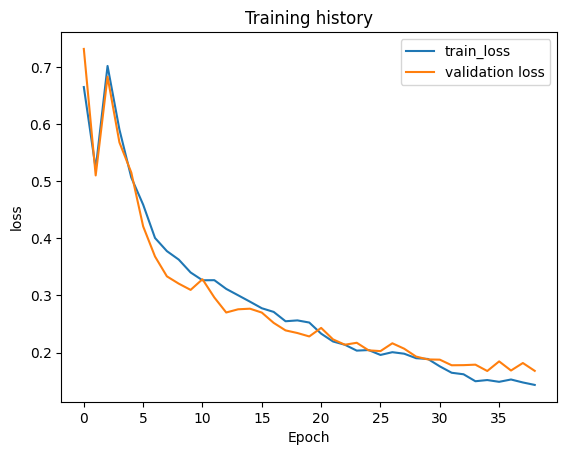

In [63]:
def plot_loss(history : dict):
  plt.plot(history['train_loss'], label='train_loss')
  plt.plot(history['val_loss'], label='validation loss')

  plt.title('Training history')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend()
plot_loss(history)

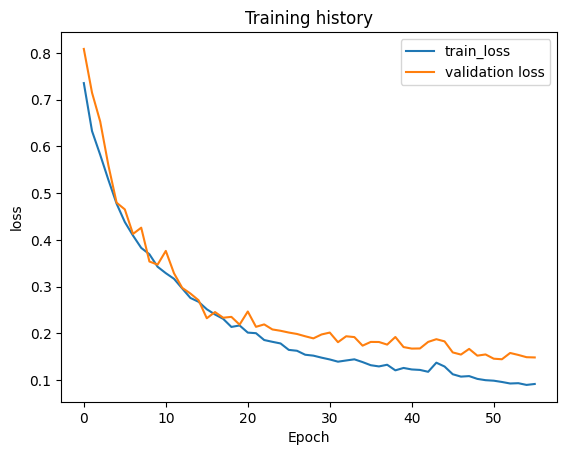

In [ ]:
def plot_loss(history : dict):
  plt.plot(history['train_loss'], label='train_loss')
  plt.plot(history['val_loss'], label='validation loss')

  plt.title('Training history')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend()
plot_loss(history)

# Predictions

In [64]:
prediction=model(torch.tensor(X_test[56][np.newaxis,...],device=DEVICE)).cpu().detach().numpy()

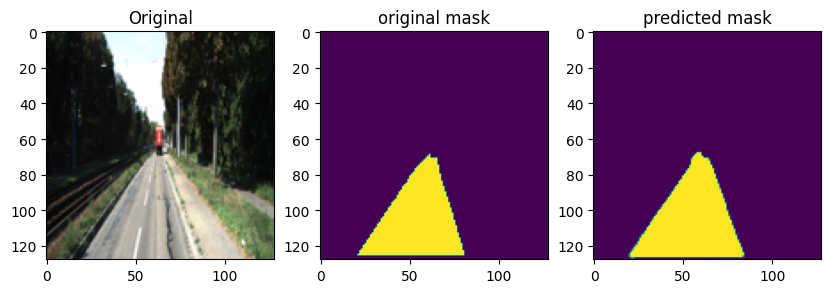

In [65]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[56].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[56].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(prediction[0].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

In [66]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:

            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())

            masks.append(outputs.cpu().detach().numpy())

            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [67]:
loss,masks=get_predicted_masks(model,test_dataloader,loss_fn,DEVICE)
print(loss)

0.11539003252983093


In [68]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

# Testing

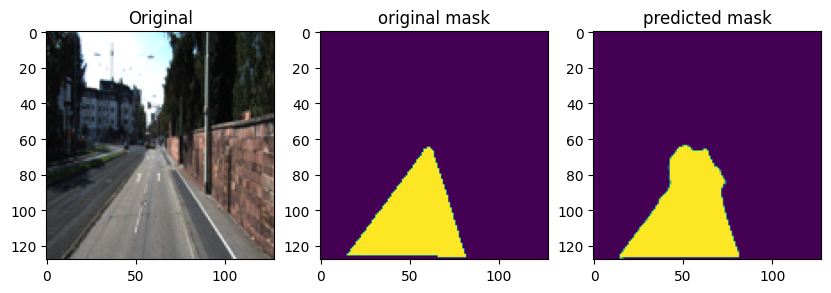

In [69]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[2].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[2].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[2].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

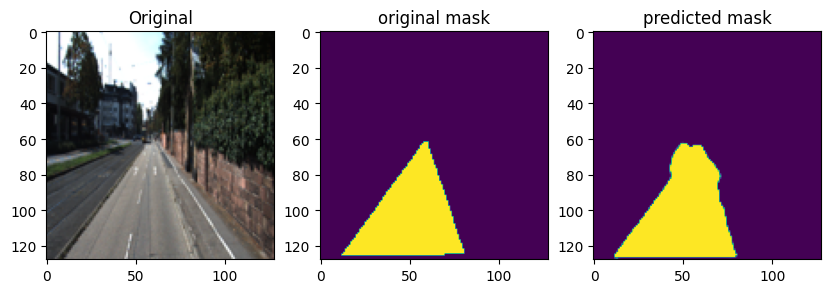

In [70]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[1].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[1].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[1].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

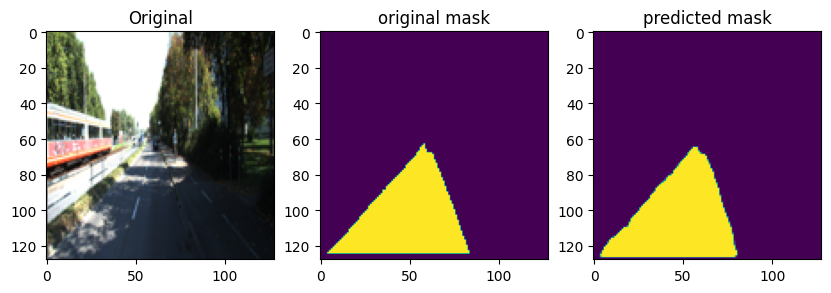

In [72]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[14].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[14].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[14].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

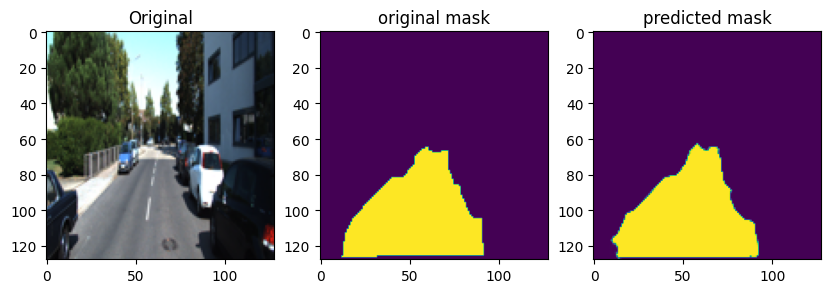

In [73]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[4].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[4].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[4].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()